In [2]:
import numpy as np
import pandas as pd
import math
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

In [2]:
%matplotlib inline  

In [3]:
mod = SourceModule("""
    #define N 1000
    
    
  
    
    
    __global__ void doIndexy(float *Z, int *indexx, int *indexy, float *pin, float *PYX,int total )
    { 
        
        int idx = blockIdx.x * blockDim.x + threadIdx.x; //this is actually j in indexy
        int t = 0; 
        if(idx >= total){
            return;
        }
        //printf("%d/n", total);
        float sum = 0;
        int j = indexy[idx]; 
        for (int i = 0; i < total ;i++){
           if(Z[indexx[i]+j-1]!=0.f){
               sum += 0.10*0.10*0.10*Z[indexx[i]+j-1]*log2(Z[indexx[i]+j-1]);
           }
           
           //printf("%d\\n", Z[0]);
        }; 
        //printf("%f/n", sum);
        PYX[idx] = sum; 
        
        //printf ("%d:::::::\\t", idx);
       
       // in[idx*(d+1)+5]=integral(in[idx*(d+1)+0],in[idx*(d+1)+1], in[idx*(d+1)+2], in[idx*(d+1)+3], in[idx*(d+1)+4]);
    }""")
mod2 = SourceModule("""

    __global__ void doIndexx(float *Z, int *indexx, int *indexy, float *pin, float *PY,int total )
    { 
        
        int idx = blockIdx.x * blockDim.x + threadIdx.x; //this is actually j in indexy
        //printf("%d\\n", idx);
        int t = 0; 
        //if(idx >= total){
          //  return;
        //}
        //printf("%d/n", total);
       float sum = 0;
       int j = indexx[idx]; 
       for (int i = 0; i < total ;i++){
           //if(Z[indexy[i]+j-1]!=0.f){
         sum += 0.10*0.10*0.10*Z[indexy[i]+j-1]*pin[i];
               
               
           //}
           
           //printf("%d\\n", Z[0]);
        }; 
        //printf("%f/n", sum);
        PY[idx] = sum; 
        //PY[idx] = idx; 
        
        //printf ("%d:::::::\\t", idx);
       
       // in[idx*(d+1)+5]=integral(in[idx*(d+1)+0],in[idx*(d+1)+1], in[idx*(d+1)+2], in[idx*(d+1)+3], in[idx*(d+1)+4]);
    }""")


/home/ranap/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(13): warning: variable "t" was declared but never referenced


/home/ranap/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(9): warning: variable "t" was declared but never referenced




In [4]:
# In[3]:
# for benchmark
start = cuda.Event()
end = cuda.Event()

In [5]:
funcxy = mod.get_function("doIndexy")
funcxx = mod2.get_function("doIndexx")

In [6]:
inP_point=21
obs_point=61
Z_point=81
bbin = 0.10


In [7]:
# Z = np.random.randn(25,3)
# Z = np.abs(Z)

In [1]:
f2 = pd.read_csv('input/savedist_4d_4_10.tsv',sep=' ',squeeze=True,header=None).values

NameError: name 'pd' is not defined

In [9]:
# for N=3 
def in_dist(a,b,tau=1):
    ps = np.empty(len(a))
    for i in range(len(a)):
        if(b[i] >= a[i]):
            ps[i] = (1/tau**2)*(math.exp(-1*b[i]/tau))
        else: 
            ps[i] = 0
    return ps
            

In [10]:
# for N=4
def in_dist4(a,b,c,tau=0.5):
    ps = np.empty(len(a))
    for i in range(len(a)):
        if(b[i] >= a[i] and c[i] >= a[i] and c[i] >= b[i]):
            ps[i] = (1/tau**3)*(math.exp(-1*c[i]/tau))
        else: 
            ps[i] = 0
    return ps

In [11]:
x, y ,z = np.meshgrid([x for x in np.arange(0,inP_point*bbin,bbin)],[x for x in np.arange(0,inP_point*bbin,bbin)] ,[x for x in np.arange(0,inP_point*bbin,bbin)])
# x, y = np.meshgrid([x for x in np.arange(0,2,1)],[x for x in np.arange(0,2,1)])

In [12]:
t = y 
y = np.reshape(x,-1)
x =np.reshape(t,-1)

In [13]:
x = np.reshape(x,-1)
y = np.reshape(y,-1)
z = np.reshape(z,-1)

In [14]:
x[0:100]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [15]:
pin = in_dist4(x,y,z, 0.5)
pin = pin.T

In [16]:
41*41*41

68921

In [17]:
indexy = np.array([],dtype=int)
for k in range (1,inP_point+1):
    for k1 in range (1,inP_point+1):
        a = [i for i in range(1+(Z_point*Z_point*(k-1))+(Z_point*(k1-1)),inP_point+1+(Z_point*Z_point*(k-1))+(Z_point*(k1-1)))] ### possible index error
        indexy =np.append(indexy,a)


In [18]:
obs_point

61

In [19]:
indexy.shape

(9261,)

In [20]:
indexx = np.array([],dtype=int)
for k in range (0,obs_point): 
    for k1 in range (0,obs_point): 
        a = [i for i in range(Z_point*Z_point*(k)+k1*(Z_point),Z_point*Z_point*(k)+k1*Z_point+obs_point)] ### possible index error
    
        indexx =np.append(indexx,a)

In [21]:
indexx.shape

(226981,)

In [22]:
indexx+indexy[-1]

array([132861, 132862, 132863, ..., 531439, 531440, 531441])

In [23]:
PYX = np.empty(len(indexy),np.float32)
PY = np.empty(len(indexx),np.float32)

In [24]:
PY.shape

(226981,)

count = 0
for j in indexy:
    A = Z[indexx+j-1]
    
    PYX [count] = bbin**3*np.sum(A*np.log2(A))
    count = count + 1

count = 0
for j in indexx:
    B = Z[indexy+j-1]
    PY [count] = bbin**3*np.sum(B*pin)
    count = count + 1

In [25]:
# PYX

In [26]:
# PY

In [27]:
Z_2 = Z

In [28]:
d_Z_2 = cuda.mem_alloc(np.float32(Z_2).nbytes)
cuda.memcpy_htod(d_Z_2, np.float32(Z_2))

d_indexx = cuda.mem_alloc(np.int32(indexx).nbytes)
cuda.memcpy_htod(d_indexx, np.int32(indexx))

d_indexy = cuda.mem_alloc(np.int32(indexy).nbytes)
cuda.memcpy_htod(d_indexy, np.int32(indexy))

d_pin = cuda.mem_alloc(np.float32(pin).nbytes) 
cuda.memcpy_htod(d_pin, np.float32(pin))

d_PYX = cuda.mem_alloc(np.float32(PYX).nbytes) 
cuda.memcpy_htod(d_PYX, np.float32(PYX))




In [29]:
# for doIndexx
d_PY = cuda.mem_alloc(np.float32(PY).nbytes) 
cuda.memcpy_htod(d_PY, np.float32(PY))

In [30]:
start.record()


In [31]:
blocksize = 16
gridsize = math.floor(len(indexy)/blocksize)+1
funcxy(d_Z_2, d_indexx, d_indexy, d_pin, d_PYX, np.int32(len(indexx)),  block=(blocksize,1,1), grid =(gridsize,1,1))

In [32]:

h_PYX = np.zeros(len(indexy), np.float32)


In [33]:
cuda.memcpy_dtoh(h_PYX, d_PYX)

In [34]:

end.record()
end.synchronize()
secs = start.time_till(end)*1e-3
# print ("N :",total)
# print ("D :",d)
print ("%fs sec" % (secs))

0.408411s sec


In [35]:
start.record()

In [36]:
blocksize = 128
gridsize = math.floor(len(indexx)/blocksize)+1
print (gridsize)
funcxx(d_Z_2, d_indexx, d_indexy, d_pin, d_PY, np.int32(len(indexy)),  block=(blocksize,1,1), grid =(gridsize,1,1))

1774


In [37]:
h_PY = np.zeros(len(indexx), np.float32)

In [38]:
cuda.memcpy_dtoh(h_PY, d_PY)

In [39]:
end.record()
end.synchronize()
secs = start.time_till(end)*1e-3
# print ("N :",total)
# print ("D :",d)
print ("%fs sec" % (secs))

0.416759s sec


In [40]:
# pd.DataFrame(h_PYX)

In [41]:
len(indexy)

9261

In [42]:
h_PY[68916:68929]

array([  1.48836509e-04,   1.36338684e-04,   1.25115708e-04,
         1.14910988e-04,   1.05685234e-04,   9.72652197e-05,
         8.96262936e-05,   8.25925090e-05,   7.59914692e-05,
         7.00335149e-05,   6.46874614e-05,   5.97473081e-05,
         5.51387566e-05], dtype=float32)

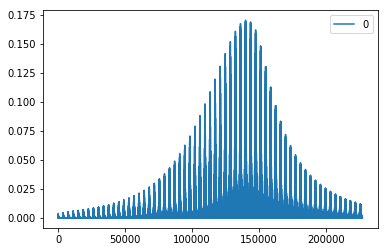

In [43]:
pd.DataFrame(h_PY).plot()

In [44]:
hy = bbin**3*np.sum(-1*h_PY[h_PY>0]*np.log2(h_PY[h_PY>0]))

In [45]:
hy

5.2702934570312516

In [46]:
hyc = -bbin**3*np.sum(pin*h_PYX.T)

In [47]:
hyc

4.8023688780925582

In [48]:
MI=hy-hyc

In [49]:
MI

0.46792457893869344

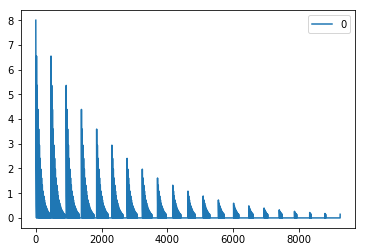

In [50]:
pd.DataFrame(pin).plot()